In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor

import os
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
import math
import random

from FEANet.mesh import MeshHandler
from FEANet.geo import Geometry
from FEANet.jacobi import JacobiBlock
from FEANet.model import KNet, FNet

from Utils import plot
from Data.dataset import RHSDataSet

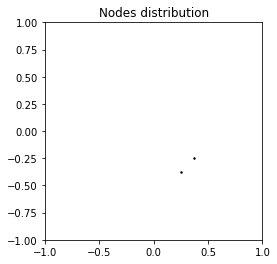

In [2]:
kernel_i = 15
n = 2**4
mesh = MeshHandler(nnode_edge = n+1, outfile="Results/plate_mesh.vtk")
plot.plot_pattern(mesh, key=kernel_i)

In [3]:
linear_tensor_R = torch.asarray([[1, 2, 1],
                                 [2, 4, 2],
                                 [1, 2, 1]], dtype=torch.float32) / 16.0
linear_tensor_P = torch.asarray([[1, 2, 1],
                                 [2, 4, 2],
                                 [1, 2, 1]], dtype=torch.float32) / 4.0
linear_ratio = torch.asarray([4.,1.], dtype=torch.float32)

In [4]:
class SingleGrid():
    '''
    Perform weighted Jacobi iteration relaxation for a single grid.
    Note: the n should be the number of intervals, e.g., 
          there are (n+1)*(n+1) grid points in total if the size is n
          f has already been convoluted, i.e., f = fnet(ff) if ff is the sourcing term of PDE
    '''
    def __init__(self, size, n):
        self.size = size # actual size of the plate
        self.n = n 
        self.omega = 2/3.
        self.property = [1, 20] # homogeneous problem
        self.plate = Geometry(nnode_edge = n+1)
        self.grid = MeshHandler(size, prop=self.property, nnode_edge=n+1)
        self.v = torch.zeros((1, 1, n+1, n+1), requires_grad=False, dtype=torch.float32)
        self.f = torch.zeros((1, 1, n+1, n+1), requires_grad=False, dtype=torch.float32)
        self.InstantiateFEANet()
        self.jac = JacobiBlock(self.Knet, self.grid, self.omega, self.plate.geometry_idx, self.plate.boundary_value)

    def IsCoarsest(self):
        return self.n == 2
        
    def InstantiateFEANet(self):
        self.Knet = KNet(self.grid) # Initialize the stiffness network, given mesh
        self.fnet = FNet(self.size/self.n) # Initialize the forcing term network, given mesh size
        for param in self.Knet.parameters():
            param.requires_grad = False
        for param in self.fnet.parameters():
            param.requires_grad = False

    def Relax(self, v, f, num_sweeps_down):
        '''
        Perform a fixed number of weighted Jacobi iteration
        '''
        v = self.jac.jacobi_convolution(v, f, n_iter=num_sweeps_down)
        return v


class RestrictionNet(nn.Module):
    '''Given an initial R kernel'''
    def __init__(self, linear_tensor_R):
        super(RestrictionNet, self).__init__()
        self.n_channel = 16
        self.net = nn.Conv2d(in_channels=self.n_channel,out_channels=1, kernel_size=3, stride=2, bias=False) # restriction
        for i in range(self.n_channel):
            self.net.state_dict()['weight'][0][i] = linear_tensor_R
    def forward(self, x_split):
        '''The input should have already been splitted'''
        return self.net(x_split)

class ProlongationNet(nn.Module):
    '''Given an initial P kernel'''
    def __init__(self, linear_tensor_P):
        super(ProlongationNet, self).__init__()
        self.n_channel = 16
        self.net = nn.ConvTranspose2d(in_channels=self.n_channel,out_channels=1, kernel_size=3, stride=2, padding=1, bias=False) # interpolation
        for i in range(self.n_channel):
            self.net.state_dict()['weight'][i][0] = linear_tensor_P
            
    def forward(self, x_split): 
        '''The input should have already been splitted'''
        return self.net(x_split)

class MultiGrid(nn.Module):
    '''Define the multigrid problem for 2D, n is the finest grid size'''
    def __init__(self, n, linear_tensor_R, linear_tensor_P, linear_ratio):
        super(MultiGrid, self).__init__()

        # Problem parameters
        self.size = 2
        self.n = n # number of grid intervals for finest grid edges
        self.L = int(np.log2(n)) # multigrid iteration
        self.solution = []
        
        self.n_arr = self.SizeArray() # array to store grid size for each level
        self.grids = self.GridDict() # dictionary of structure grids
        
        # Inter-grid communication network models
        self.conv = RestrictionNet(linear_tensor_R)
        self.deconv = ProlongationNet(linear_tensor_P)
        self.w = nn.Parameter(linear_ratio)
        
        self.conv.requires_grad_(True)
        self.deconv.requires_grad_(True)
        self.w.requires_grad_(False)
    
    def GridDict(self):
        grids = {}
        for i in range(self.L):
            grids[i] = SingleGrid(self.size, self.n_arr[i])
        return grids

    def SizeArray(self):
        n_arr = []
        for i in range(self.L):
            n_arr.append(int(self.n/(2.**i)))
        n_arr = np.array(n_arr)
        return n_arr

    def Restrict(self, rF):
        '''
        Perform restriction operation to down sample to next (coarser) level
        Note: rF has already been splitted
        '''
        rFC = self.conv(rF[:, :, 1:-1, 1:-1].clone())
        rFC = F.pad(rFC,(1,1,1,1),"constant",0) # pad the coarse-level residual with zeros
        return rFC

    def Interpolate(self, eFC):
        '''
        Perform interpolation and upsample to previous (finer) level 
        Note: eFC has already been splitted
        '''
        eF = self.deconv(eFC.clone())
        return eF 

    def loss(self, x):
        "Compute the loss after m iterations"
        res1 = self.f - self.grids[0].Knet(x)
        return torch.mean(torch.norm(res1[:, :, 1:-1, 1:-1].clone(), dim=(2,3)))

    def random_sampling(self, v):
        d1, d2, d3, d4 = v.shape
        for i in range(d1):
            for j in range(d2):
                coef = 10*np.random.rand(2) - 5
                v[i, j, :, :] = torch.from_numpy(coef[0]*np.random.random((d3,d4)) + coef[1])

    def forward(self, F):
        '''Input is RHS field F'''
        self.f = self.grids[0].fnet(F) # assign the finest rhs 
        self.v = torch.zeros_like(F, requires_grad=False, dtype=torch.float32) # initial solution
        self.random_sampling(self.v)
        U = torch.clone(self.v)
        return self.iterate(U, self.f)

    def iterate(self, x, f):
        '''Input x is the initial solution on the finest grid'''
        n_batches = x.shape[0]
        n_relax = 1 # number of relaxations
        self.grids[0].v = x
        self.grids[0].f = f
        self.grids[0].v = self.grids[0].Relax(self.grids[0].v, self.grids[0].f, n_relax)

        for j in range(0, self.L-1):
            rF = self.grids[j].f-self.grids[j].Knet(self.grids[j].v)
            rF = self.grids[j].Knet.split_x(rF)
            self.grids[j+1].f = self.w[0]*self.Restrict(rF)
            self.grids[j+1].v = torch.zeros((n_batches,1,self.n_arr[j+1]+1,self.n_arr[j+1]+1), dtype=torch.float32, requires_grad=False)
            self.grids[j+1].v = self.grids[j+1].Relax(self.grids[j+1].v, self.grids[j+1].f, n_relax)

        self.grids[self.L-1].v = self.grids[self.L-1].Relax(self.grids[self.L-1].v, self.grids[self.L-1].f, n_relax)

        for j in range(self.L-2,-1,-1):
            eFC = self.grids[j+1].Knet.split_x(self.grids[j+1].v)
            eF_delta = self.w[1]*self.Interpolate(eFC)
            self.grids[j].v = self.grids[j].v + eF_delta
            self.grids[j].v = self.grids[j].Relax(self.grids[j].v, self.grids[j].f, n_relax)

            # zero out the previous level solution
            self.grids[j+1].v = torch.zeros((n_batches,1,self.n_arr[j+1]+1,self.n_arr[j+1]+1), dtype=torch.float32, requires_grad=False) 

        return self.grids[0].v 

In [5]:
model = MultiGrid(n, linear_tensor_R, linear_tensor_P, linear_ratio)

In [6]:
model_dir = 'Model/multigrid_rhs_res'
if not os.path.exists(model_dir):
    os.makedirs(model_dir)
    
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
mlist = list(model.parameters())
print('Ratio:', mlist[0][:])
print('Restriction kernel:', mlist[1][0][0])
print('Restriction kernel shape:', mlist[1].shape)
print('Interpolation kernel:', mlist[2][0][0])
print('Interpolation kernel shape:', mlist[2].shape)

Ratio: tensor([4., 1.])
Restriction kernel: tensor([[0.0625, 0.1250, 0.0625],
        [0.1250, 0.2500, 0.1250],
        [0.0625, 0.1250, 0.0625]], grad_fn=<SelectBackward0>)
Restriction kernel shape: torch.Size([1, 16, 3, 3])
Interpolation kernel: tensor([[0.2500, 0.5000, 0.2500],
        [0.5000, 1.0000, 0.5000],
        [0.2500, 0.5000, 0.2500]], grad_fn=<SelectBackward0>)
Interpolation kernel shape: torch.Size([16, 1, 3, 3])


Text(0.5, 0, 'epoch')

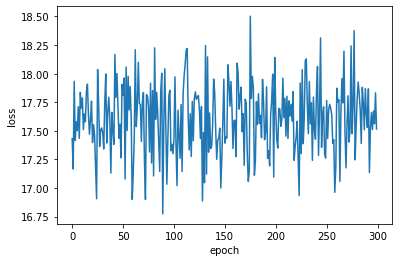

In [7]:
# load the training loss
model_name = 'model_mg_interface_kernel'+str(kernel_i)
qm_train = np.load(os.path.join(model_dir,model_name+'.npy'))
plt.plot(qm_train)
plt.ylabel('loss')
plt.xlabel('epoch')

In [8]:
# import the learned model
model.load_state_dict(torch.load(os.path.join(model_dir,model_name+'.pth')))

<All keys matched successfully>

In [9]:
print('Learned parameters:')
print('Ratio:', mlist[0][:])
print('Restriction kernel:', mlist[1][0][kernel_i])
print('Interpolation kernel:', mlist[2][kernel_i][0])

print()

print('Previous parameters:')
print('Ratio:', mlist[0][:])
print('Restriction kernel:', mlist[1][0][kernel_i-1])
print('Interpolation kernel:', mlist[2][kernel_i-1][0])

Learned parameters:
Ratio: tensor([4., 1.])
Restriction kernel: tensor([[-0.0864,  0.1255, -0.0103],
        [ 0.1241,  0.2500,  0.1566],
        [-0.0165,  0.1487,  0.3970]], grad_fn=<SelectBackward0>)
Interpolation kernel: tensor([[0.2942, 0.5086, 0.2585],
        [0.5058, 0.9959, 0.4992],
        [0.2598, 0.4983, 0.2513]], grad_fn=<SelectBackward0>)

Previous parameters:
Ratio: tensor([4., 1.])
Restriction kernel: tensor([[0.0625, 0.1250, 0.0625],
        [0.1250, 0.2500, 0.1250],
        [0.0625, 0.1250, 0.0625]], grad_fn=<SelectBackward0>)
Interpolation kernel: tensor([[0.2500, 0.5000, 0.2500],
        [0.5000, 1.0000, 0.5000],
        [0.2500, 0.5000, 0.2500]], grad_fn=<SelectBackward0>)


In [10]:
# Test the multigrid iteration
class mgTest(MultiGrid):
    '''Define the multigrid problem for 2D, n is the finest grid size'''
    def __init__(self, inter_model, n = 64):
        super(mgTest, self).__init__(n, linear_tensor_R, linear_tensor_P, linear_ratio)

        self.size = 2
        self.n = n # total number of grids for finest grid
        self.L = int(np.log2(n)) # number of levels for V-cycle multigrid
        self.x = np.linspace(-1,1,n+1, dtype=np.float32) # grid number is n+1
        self.y = np.linspace(-1,1,n+1, dtype=np.float32)
        self.xx, self.yy = np.meshgrid(self.x, self.y, indexing='xy')
        self.solution = []

        self.w = inter_model.w
        self.conv = inter_model.conv
        self.deconv = inter_model.deconv
        self.conv.requires_grad_(False)
        self.deconv.requires_grad_(False)
        self.w.requires_grad_(False)
        
        self.n_arr = self.SizeArray() # array to store grid size for each level
        self.grids = self.GridDict() # dictionary of structure grids
        
        ff = np.ones_like(self.xx)
        self.grids[0].f = self.grids[0].fnet(torch.from_numpy(ff.reshape(1,1,n+1,n+1))) # assign the finest right hand side with the original rhs
    
    def solve(self):
        '''Return error and residual array'''
        EPS = 5e-5
        n_Vcycle = 0
        self.grids[0].v = torch.zeros((1, 1, self.n+1, self.n+1), requires_grad=False, dtype=torch.float32)
        e_Vcycle, res = 1, 1
        e_arr_Vcycle = [e_Vcycle]
        res_arr_Vcycle = [res]
        err_occured = False
        while (res > EPS):
            u_prev = self.grids[0].v 
            self.grids[0].v = self.iterate(self.grids[0].v,self.grids[0].f)
            e_Vcycle = torch.sqrt(torch.sum((self.grids[0].v - u_prev) ** 2)).item() / torch.sqrt(torch.sum((self.grids[0].v) ** 2)).item()
            e_arr_Vcycle.append(e_Vcycle)
            residual = self.grids[0].f-self.grids[0].Knet(self.grids[0].v)
            res = torch.sqrt(torch.sum(residual[:, :, 1:-1, 1:-1] ** 2)).item()
            res_arr_Vcycle.append(res)
            print(e_Vcycle, res)
            n_Vcycle += 1
            if(res == torch.inf or math.isnan(res)):
                err_occured = True
                break

        if(err_occured):
            print("The iteration doesn't converge!")
        else:
            print("Solution converges after", n_Vcycle, "V-cycle iterations with relative error of", e_Vcycle)
        return e_arr_Vcycle, res_arr_Vcycle

1.0 0.10455120354890823
0.02367435401381903 0.030201556161046028
0.015404758663046738 0.01385458279401064
0.003513417857498717 0.0072425841353833675
0.0019544375426497566 0.003907394129782915
0.0009519134736925682 0.002123358193784952
0.0004984821863097808 0.001153145101852715
0.0002633144152186423 0.0006249715224839747
0.0001413973843567803 0.0003396513347979635
7.257819906045175e-05 0.00018287634884472936
3.738478863083456e-05 9.935638809110969e-05
2.729123454621686e-05 5.501367195392959e-05
9.843574795937991e-06 3.068756268476136e-05
Solution converges after 13 V-cycle iterations with relative error of 9.843574795937991e-06


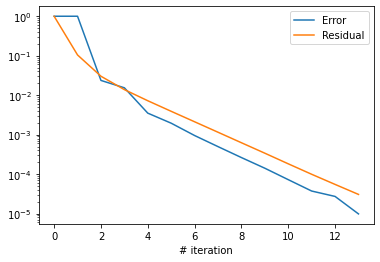

In [11]:
# Multigrid implementation
n = 2**6
prob_mg = mgTest(model, n)

e_arr_Vcycle, res_arr_Vcycle = prob_mg.solve()

plt.plot(e_arr_Vcycle, label='Error')
plt.plot(res_arr_Vcycle, label='Residual')
plt.yscale('log')
plt.xlabel('# iteration')
#plt.ylabel('Error')
plt.legend()

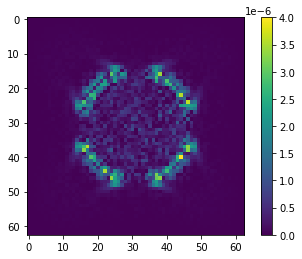

In [12]:
# Residual plots (except for boundaries)
residual = prob_mg.grids[0].f-prob_mg.grids[0].Knet(prob_mg.grids[0].v)
plot.plot_field(torch.abs(residual[:, :, 1:-1, 1:-1]),limit=[0,4e-6])

In [13]:
def compute_q(res_arr):
    return np.power(res_arr[9]/res_arr[6], 1.0/4)

print("q is: ", compute_q(res_arr_Vcycle))

q is:  0.6324155148737746
